In [1]:
%cd ..

/home/akajal/DiVAE


In [1]:
# Python imports
import os
import sys

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# ML imports
import torch
import matplotlib.pyplot as plt
import numpy as np

# DiVAE imports
from models.rbm.chimeraRBM import ChimeraRBM
from models.rbm.rbm import RBM
from models.samplers.pcd import PCD

from utils import *

# DWave imports
from dwave.system import DWaveSampler, LeapHybridSampler
import neal

ModuleNotFoundError: No module named 'DiVAE'

In [71]:
def beta_estimation_ising(num_iterations=100, lr=0.01, beta_init=5., n_reads=1000, crbm_sampler=None, dwave_sampler=None):
    assert crbm_sampler is not None
    assert dwave_sampler is not None
    
    beta = beta_init
    betas = [beta]
    
    crbm = crbm_sampler.get_rbm()
    crbm_weights, crbm_vbias, crbm_hbias = crbm.weights, crbm.visible_bias, crbm.hidden_bias
    
    ising_weights = crbm_weights/4.
    ising_vbias = crbm_vbias/2. + torch.sum(crbm_weights, dim=1)/4.
    ising_hbias = crbm_hbias/2. + torch.sum(crbm_weights, dim=0)/4.
    
    n_vis = len(crbm.visible_qubit_idxs)
    qubit_idxs = crbm.visible_qubit_idxs+crbm.hidden_qubit_idxs
    
    visible_idx_map_inv = {i:visible_qubit_idx for i, visible_qubit_idx in enumerate(crbm.visible_qubit_idxs)}
    hidden_idx_map_inv = {i:hidden_qubit_idx for i, hidden_qubit_idx in enumerate(crbm.hidden_qubit_idxs)}
    
    for i in range(num_iterations):
        dwave_weights, dwave_vbias, dwave_hbias = ising_weights/beta, ising_vbias/beta, ising_hbias/beta
        
        # Calculate the autoscale factor used to fit the parameters on the device
        j_max = float(torch.max(dwave_weights))
        j_min = float(torch.min(dwave_weights))
        
        h_max = max(float(torch.max(dwave_vbias)), float(torch.max(dwave_hbias)))
        h_min = min(float(torch.min(dwave_vbias)), float(torch.min(dwave_hbias)))
        
        autoscale = max(max(j_max,0), max(j_min/-2., 0), max(h_max/2., 0), max(h_min/-2., 0))
        print(i, autoscale)
        
        dwave_weights_np = dwave_weights.detach().cpu().numpy()
        
        biases = torch.cat((dwave_vbias, dwave_hbias)).detach().cpu().numpy()
        h = {qubit_idx:bias/autoscale for qubit_idx, bias in zip(qubit_idxs, biases)}
        J = {}
        for row in range(dwave_weights_np.shape[0]):
            for col in range(dwave_weights_np.shape[1]):
                if dwave_weights_np[row][col] != 0:
                    J[(visible_idx_map_inv[row], hidden_idx_map_inv[col])] = dwave_weights_np[row][col]/autoscale
                    
        response = dwave_sampler.sample_ising(h, J, num_reads=n_reads, auto_scale=False)
        dwave_samples, dwave_energies = batch_dwave_samples(response)
        dwave_samples = torch.from_numpy(dwave_samples).float()
        dwave_vis, dwave_hid = dwave_samples[:, :n_vis], dwave_samples[:, n_vis:]
        
        dwave_energy_exp = sample_energies_exp(dwave_weights, dwave_vbias, dwave_hbias, dwave_vis, dwave_hid)
        dwave_energy_exp = torch.mean(dwave_energy_exp, axis=0)
        
        crbm_vis, crbm_hid = crbm_sampler.block_gibbs_sampling()
        
        zero = torch.tensor(0., dtype=torch.float)
        minus_one = torch.tensor(-1., dtype=torch.float)
        
        crbm_vis = torch.where(crbm_vis == zero, minus_one, crbm_vis)
        crbm_hid = torch.where(crbm_hid == zero, minus_one, crbm_hid)
        
        crbm_energy_exp = sample_energies_exp(dwave_weights, dwave_vbias, dwave_hbias, crbm_vis, crbm_hid)
        crbm_energy_exp = torch.mean(crbm_energy_exp, axis=0)
        
        beta = beta + lr*(float(crbm_energy_exp) - float(dwave_energy_exp/autoscale))
        betas.append(beta)
        
    return betas

In [72]:
_NUM_NODES = 16
crbm_1 = ChimeraRBM(n_visible=_NUM_NODES, n_hidden=_NUM_NODES)
crbm_sampler_1 = PCD(batch_size=1024, RBM=crbm_1, n_gibbs_sampling_steps=100)

sa_sampler = neal.SimulatedAnnealingSampler()

In [73]:
betas = beta_estimation_ising(num_iterations=100, lr=0.01, beta_init=5., n_reads=1024, crbm_sampler=crbm_sampler_1, dwave_sampler=sa_sampler)

0 0.1758566051721573
1 0.18811258673667908
2 0.20224793255329132
3 0.21875569224357605
4 0.2382933795452118
5 0.2617482841014862
6 0.2905617356300354
7 0.32677510380744934
8 0.37387946248054504
9 0.4375624656677246
10 0.5291095972061157
11 0.6732576489448547
12 0.9384805560112
13 1.606774926185608
14 8.710783004760742
15 0.9251030087471008
16 0.918319582939148
17 0.9094379544258118
18 0.9022500514984131
19 0.8953417539596558
20 0.886755108833313
21 0.878100574016571
22 0.8693733215332031
23 0.861196756362915
24 0.8513846397399902
25 0.8424914479255676
26 0.8336820602416992
27 0.8222466707229614
28 0.8125508427619934
29 0.8012678623199463
30 0.7909600734710693
31 0.7787378430366516
32 0.7659085392951965
33 0.7542469501495361
34 0.7413416504859924
35 0.7291715145111084
36 0.7155790328979492
37 0.7026557922363281
38 0.6888711452484131
39 0.6761137247085571
40 0.6626166105270386
41 0.649248480796814
42 0.6358548998832703
43 0.6226834058761597
44 0.6087679266929626
45 0.5955927968025208
46 

In [34]:
def plot_betas(betas):
    """
    Plot the estimates of beta during the beta estimation procedure   
    """
    fig, ax = plt.subplots(figsize=(40, 16))
    
    plt.plot(np.arange(len(betas)), betas, marker='o', markersize=20)
    
    ax.set_xlabel("Iteration", fontsize=60)
    ax.set_ylabel("Beta", fontsize=60)
    
    ax.tick_params(axis='both', which='major', labelsize=60)
    ax.grid(True, which='both')
    
    plt.show()
    plt.close()

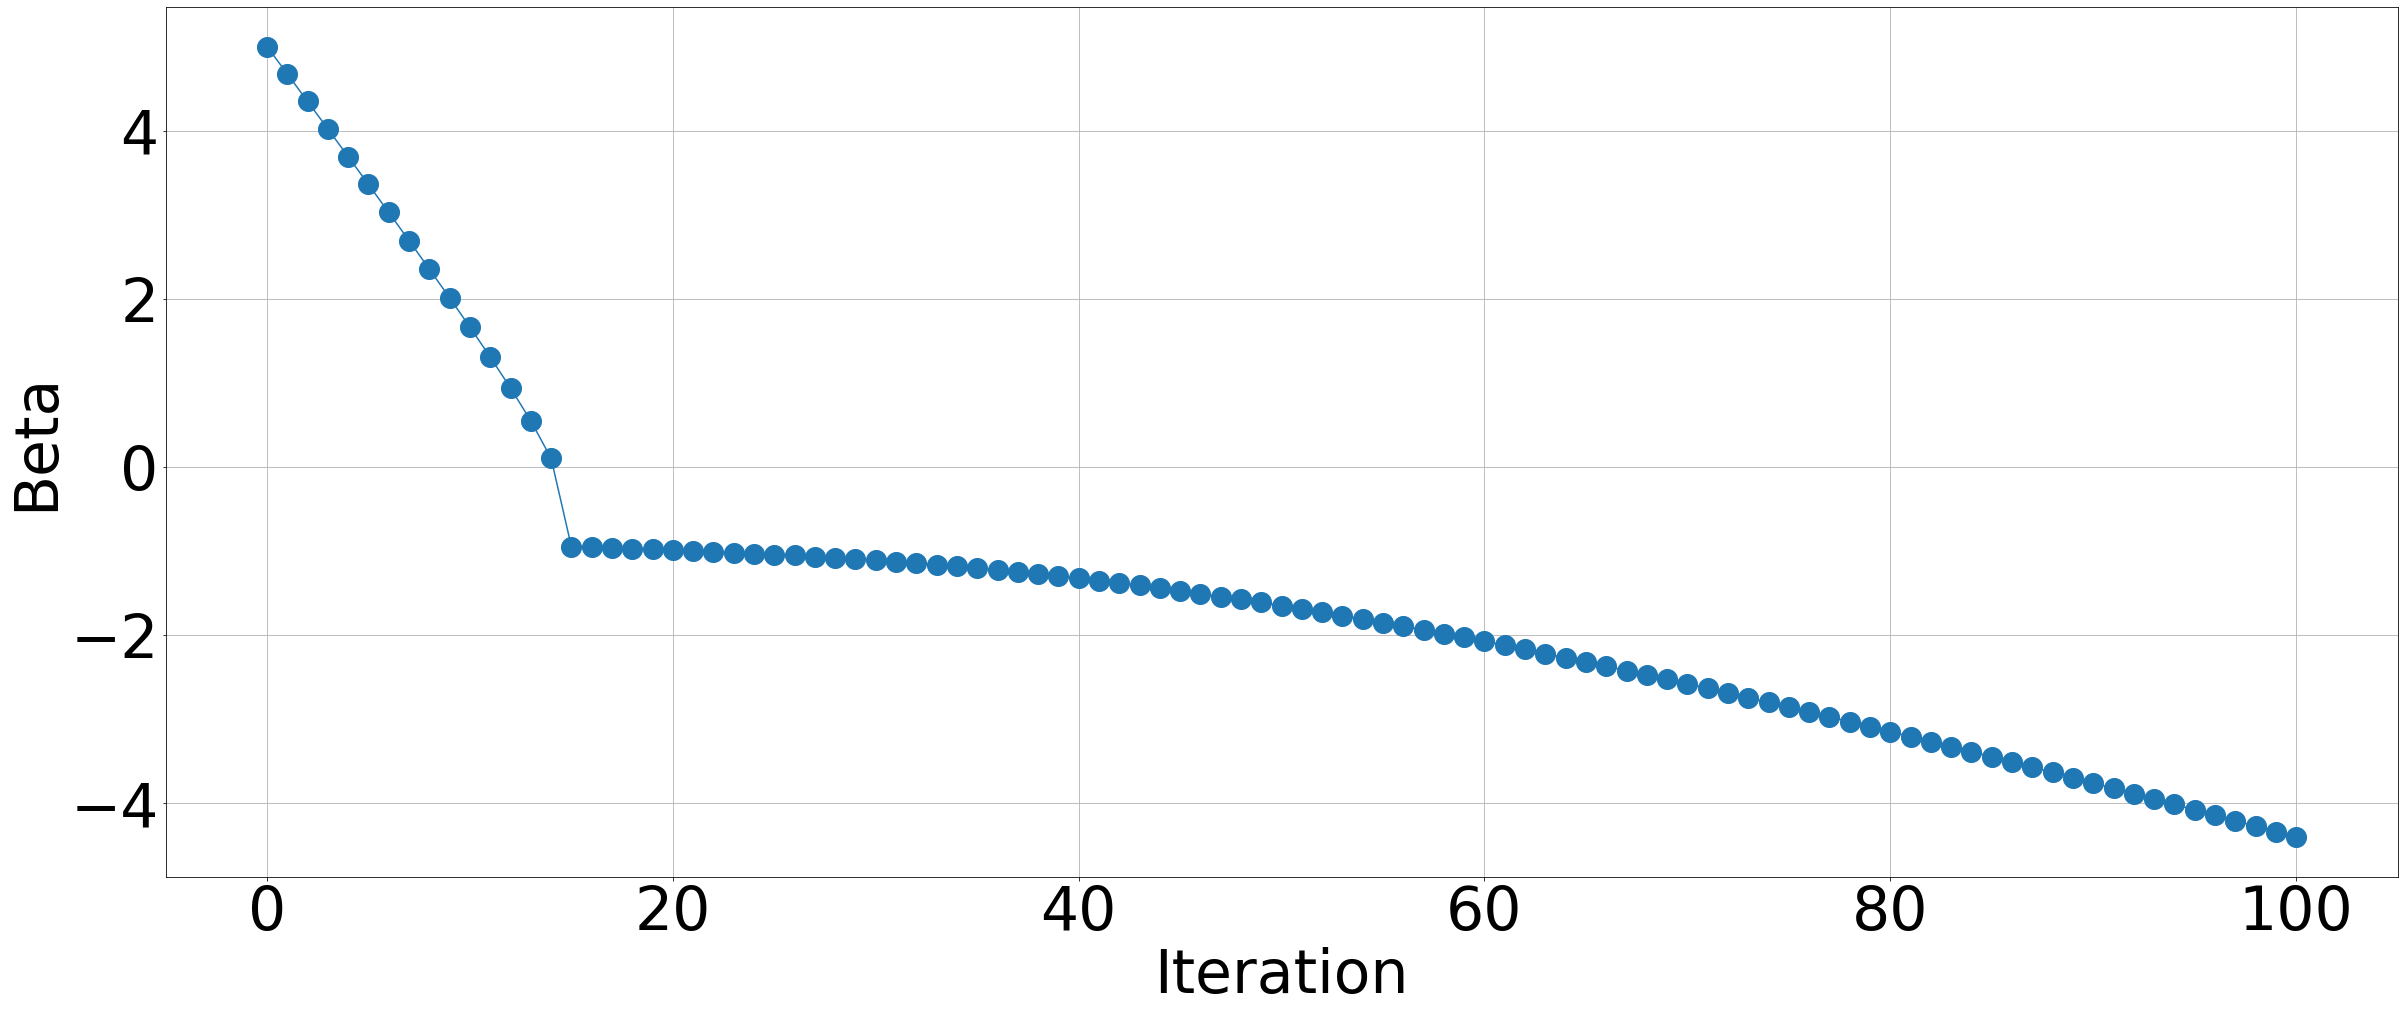

In [74]:
plot_betas(betas)

In [ ]:
def beta_estimation_ising_classical(num_iterations=100, lr=0.01, beta_init=5.,crbm_sampler_1=None, crbm_sampler_2=None):
    assert crbm_sampler_1 is not None and crbm_sampler_2 is not None
    
    beta = beta_init
    betas = [beta]
    
    crbm = crbm_sampler_1.get_rbm()
    crbm_weights, crbm_vbias, crbm_hbias = crbm.weights, crbm.visible_bias, crbm.hidden_bias
    
    ising_weights = crbm_weights/4.
    ising_vbias = crbm_vbias/2. + torch.sum(crbm_weights, dim=0)/4.
    ising_hbias = crbm_hbias/2. + torch.sum(crbm_weights, dim=1)/4.
    
    crbm_2 = crbm_sampler_2.get_rbm()
    
    for i in range(num_iterations):
        crbm_2._weights = torch.nn.Parameter(ising_weights/beta)
        crbm_2._visible_bias = torch.nn.Parameter(ising_vbias/beta)
        crbm_2._hidden_bias = torch.nn.Parameter(ising_hbias/beta)
        
        zero = torch.tensor(0., dtype=torch.float)
        minus_one = torch.tensor(-1., dtype=torch.float)
        
        crbm_vis_1, crbm_hid_1 = crbm_sampler_1.block_gibbs_sampling()
        crbm_vis_1 = torch.where(crbm_vis_1 == zero, minus_one, crbm_vis_1)
        crbm_hid_1 = torch.where(crbm_hid_1 == zero, minus_one, crbm_hid_1)
        
        crbm_energy_exp_1 = sample_energies_exp(crbm_2._weights, crbm_2._visible_bias, crbm_2._hidden_bias,
                                                crbm_vis_1, crbm_hid_1)
        crbm_energy_exp_1 = torch.mean(crbm_energy_exp_1, axis=0)
        
        crbm_vis_2, crbm_hid_2 = crbm_sampler_2.block_gibbs_sampling()
        crbm_vis_2 = torch.where(crbm_vis_2 == zero, minus_one, crbm_vis_2)
        crbm_hid_2 = torch.where(crbm_hid_2 == zero, minus_one, crbm_hid_2)
        
        crbm_energy_exp_2 = sample_energies_exp(crbm_2._weights, crbm_2._visible_bias, crbm_2._hidden_bias,
                                                crbm_vis_2, crbm_hid_2)
        crbm_energy_exp_2 = torch.mean(crbm_energy_exp_2, axis=0)
        
        beta = beta + lr*(float(crbm_energy_exp_1) - float(crbm_energy_exp_2))
        betas.append(beta)
        
    return betas

In [ ]:
_NUM_NODES = 16
crbm_1 = ChimeraRBM(n_visible=_NUM_NODES, n_hidden=_NUM_NODES)
crbm_sampler_1 = PCD(batch_size=1024, RBM=crbm_1, n_gibbs_sampling_steps=100)

crbm_2 = ChimeraRBM(n_visible=_NUM_NODES, n_hidden=_NUM_NODES)
crbm_sampler_2 = PCD(batch_size=1024, RBM=crbm_2, n_gibbs_sampling_steps=100)

In [ ]:
betas = beta_estimation_ising_classical(num_iterations=100, lr=0.1, beta_init=2.,crbm_sampler_1=crbm_sampler_1, crbm_sampler_2=crbm_sampler_2)

In [ ]:
plot_betas(betas)

In [75]:
_NUM_NODES = 16
crbm = ChimeraRBM(n_visible=_NUM_NODES, n_hidden=_NUM_NODES)
crbm_sampler = PCD(batch_size=1024, RBM=crbm, n_gibbs_sampling_steps=100)

qpu_sampler = DWaveSampler(solver={"topology__type":"chimera"})

2022-02-21 13:05:07,143 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[13:05:07.143] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2022-02-21 13:05:07,767 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='DW_2000Q_6')
[13:05:07.767] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='DW_2000Q_6')
2022-02-21 13:05:07,891 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='Advantage_system4.1')
[13:05:07.891] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='Advantage_system4.1')


In [ ]:
betas = beta_estimation_ising(num_iterations=100, lr=0.1, beta_init=2., n_reads=1024, crbm_sampler=crbm_sampler, dwave_sampler=qpu_sampler)

In [ ]:
plot_betas(betas)

In [ ]:
betas = beta_estimation_ising(num_iterations=10, lr=0.1, beta_init=5., n_reads=100, crbm_sampler=crbm_sampler, dwave_sampler=qpu_sampler)

In [ ]:
plot_betas(betas)

In [ ]:
betas = beta_estimation_ising(num_iterations=10, lr=0.01, beta_init=5., n_reads=100, crbm_sampler=crbm_sampler, dwave_sampler=qpu_sampler)
plot_betas(betas)

In [5]:
# DiVAE imports
from models.rbm.qimeraRBM import QimeraRBM

In [76]:
_NUM_NODES = 128
crbm = QimeraRBM(n_visible=_NUM_NODES, n_hidden=_NUM_NODES)
crbm_sampler = PCD(batch_size=1024, RBM=crbm, n_gibbs_sampling_steps=100)

qpu_sampler = DWaveSampler(solver={"topology__type":"chimera"})

2022-02-21 13:05:15,130 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[13:05:15.130] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2022-02-21 13:05:16,699 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='DW_2000Q_6')
[13:05:16.699] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='DW_2000Q_6')
2022-02-21 13:05:16,833 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='Advantage_system4.1')
[13:05:16.833] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='Advantage_system4.1')
2022-02-21 13:05:17,074 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[13:05:17.074] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2022-02-21 13:05:17,612 dwave.cloud.client.base INFO  Main

0 0.22179071605205536
1 0.08166317641735077
2 0.06441459059715271
3 0.053139280527830124
4 0.04503351077437401
5 0.03900302201509476
6 0.03434961661696434
7 0.030736960470676422
8 0.0277241263538599
9 0.02520311437547207


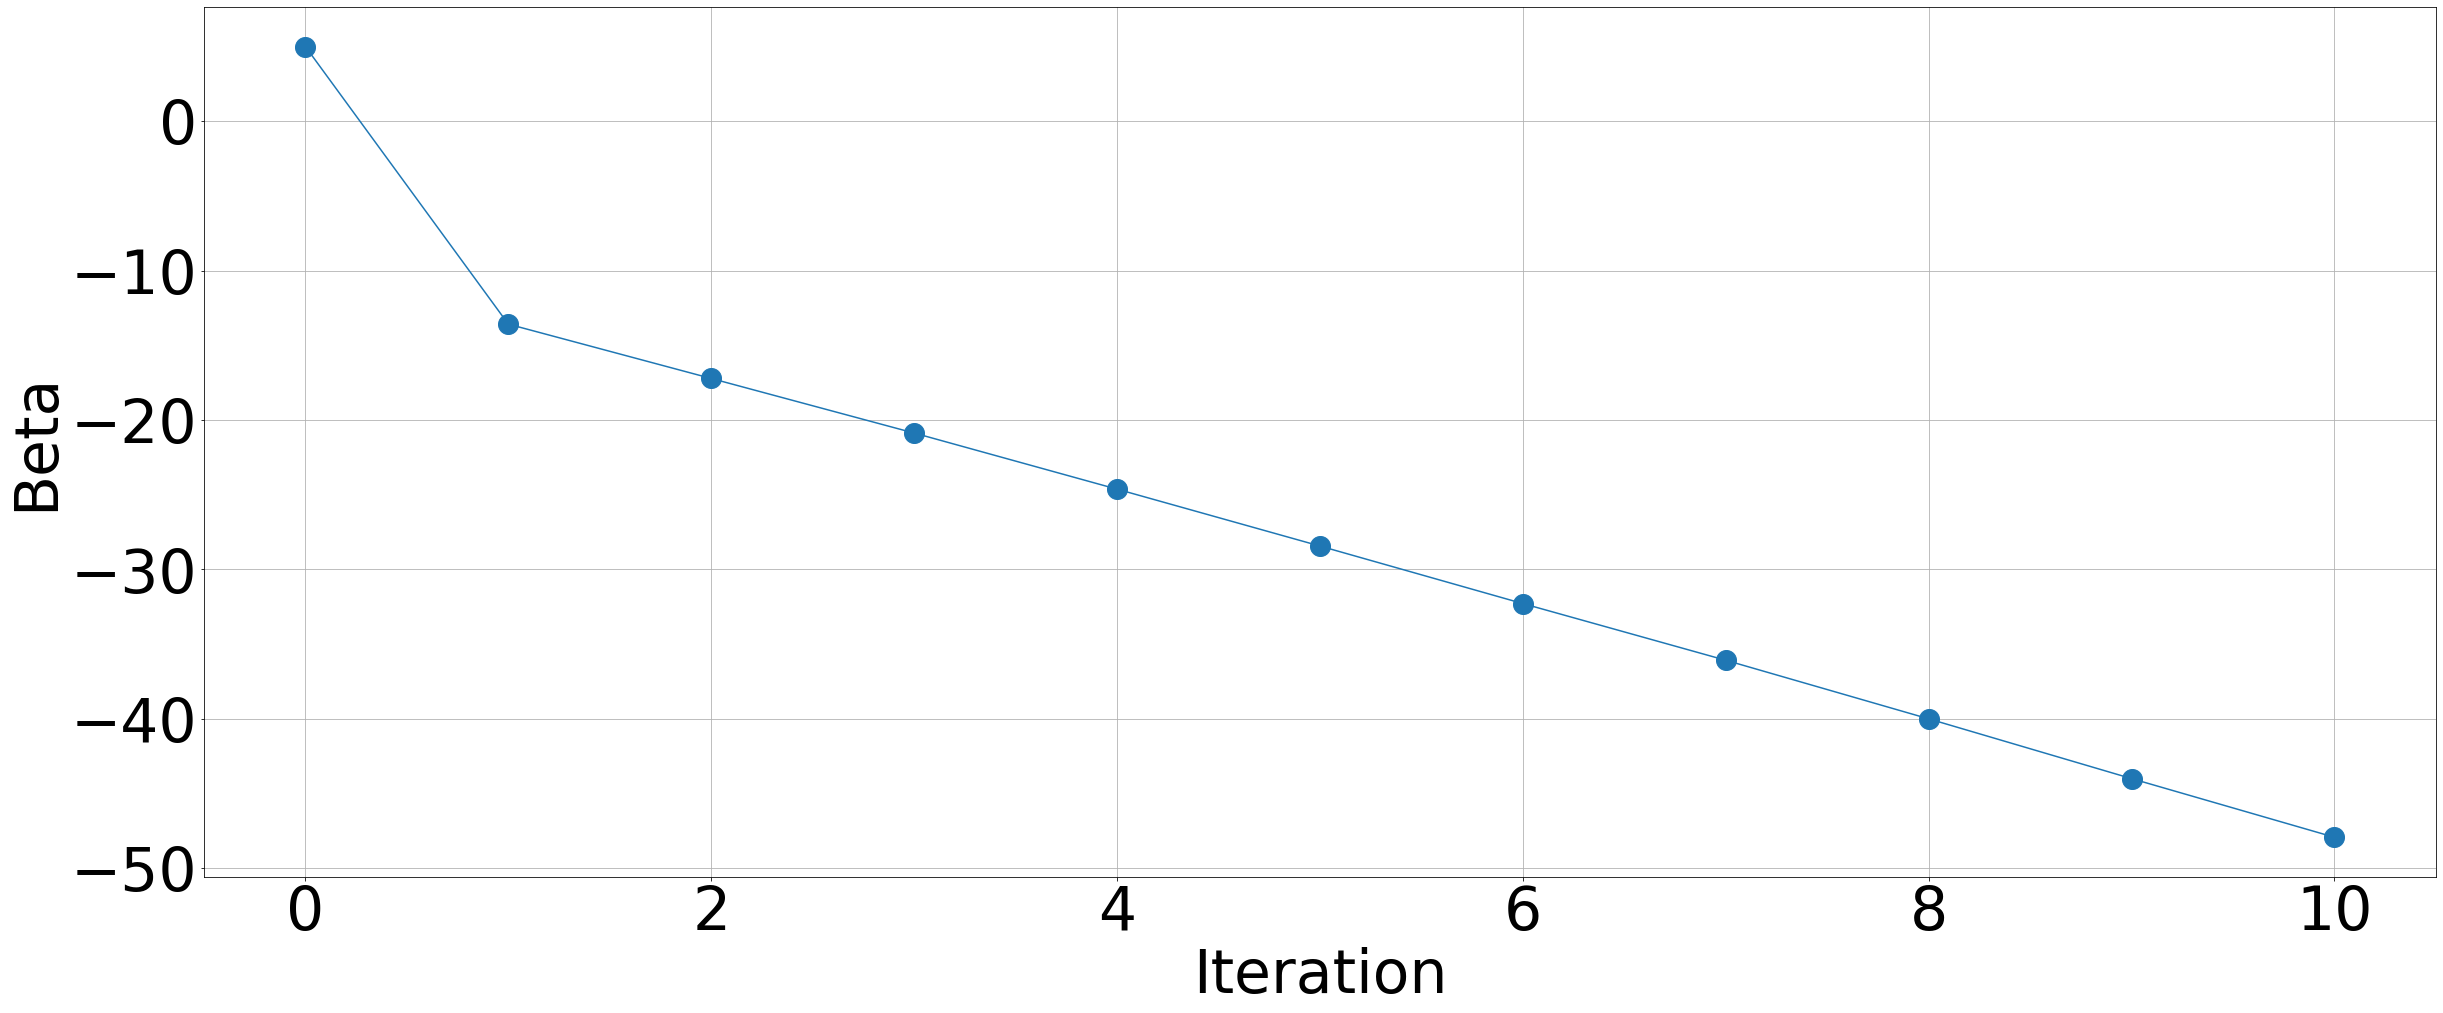

In [77]:
betas = beta_estimation_ising(num_iterations=10, lr=0.1, beta_init=5., n_reads=100,
                              crbm_sampler=crbm_sampler, dwave_sampler=qpu_sampler)
plot_betas(betas)

0 0.10972309112548828
1 0.1134333610534668
2 0.11754892766475677
3 0.12220253050327301
4 0.12753334641456604
5 0.1336447149515152
6 0.14075352251529694
7 0.1492568850517273
8 0.15965686738491058
9 0.17276835441589355
10 0.1901259422302246
11 0.21425898373126984
12 0.2520461976528168
13 0.32266655564308167
14 0.5342220664024353
15 2.407726764678955
16 0.8537194132804871
17 1.1123473644256592
18 1.4974863529205322
19 1.7198460102081299
20 1.531130075454712
21 1.6852823495864868
22 1.584831714630127
23 1.5988786220550537
24 1.653551459312439
25 1.6126608848571777
26 1.6637762784957886
27 1.6357780694961548
28 1.6198585033416748
29 1.6298513412475586
30 1.6450313329696655
31 1.6438283920288086
32 1.6114052534103394
33 1.6461329460144043
34 1.6420698165893555
35 1.6230800151824951
36 1.6536314487457275
37 1.6295217275619507
38 1.6427910327911377
39 1.676755666732788
40 1.6214375495910645
41 1.6117621660232544
42 1.6121482849121094
43 1.6465998888015747
44 1.5906643867492676
45 1.65303087234

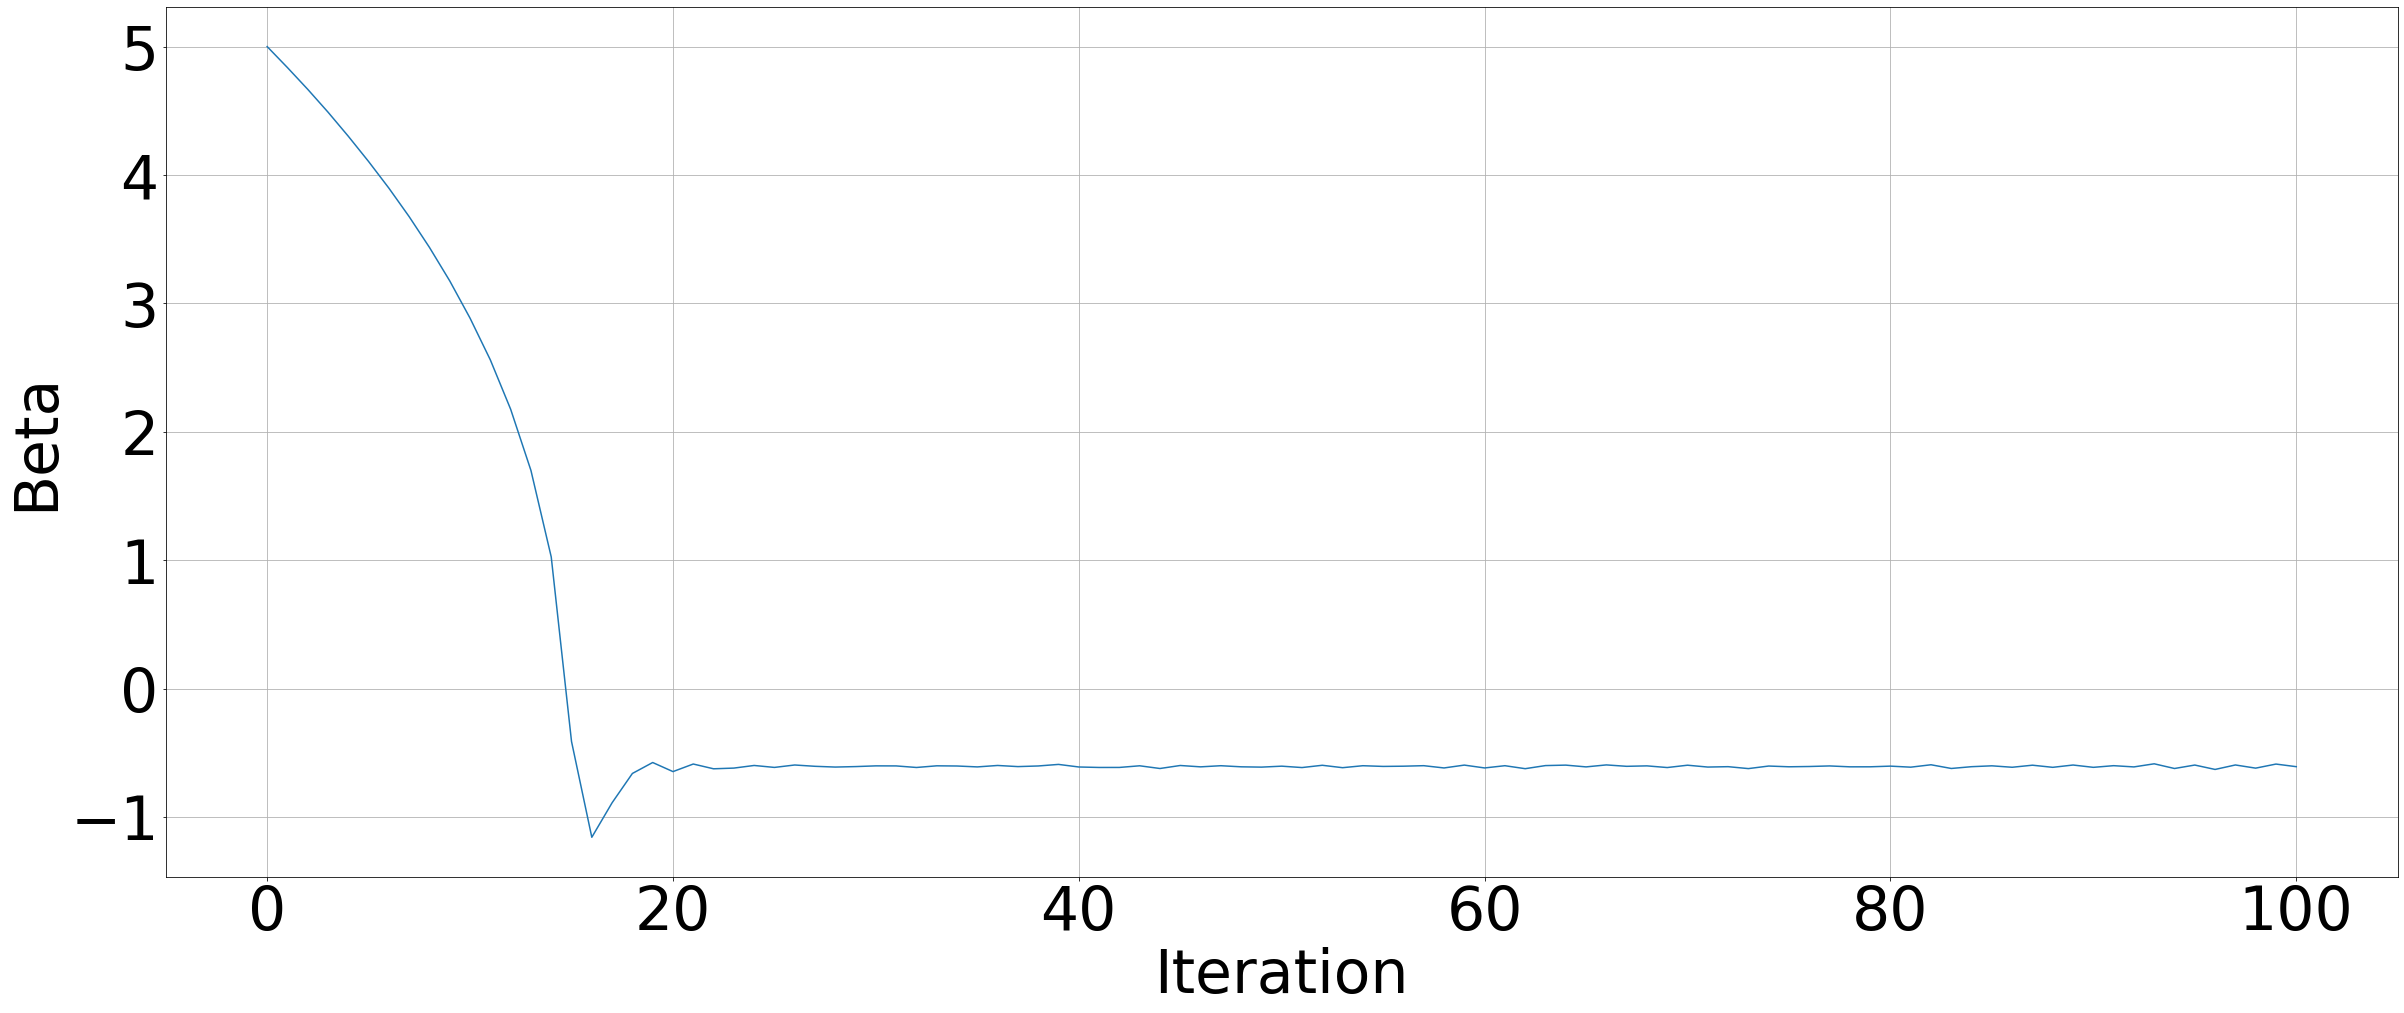

In [19]:
sa_sampler = neal.SimulatedAnnealingSampler()
betas = beta_estimation_ising(num_iterations=100, lr=0.01, beta_init=5., n_reads=100,
                              crbm_sampler=crbm_sampler, dwave_sampler=sa_sampler)
plot_betas(betas)

In [20]:
_NUM_NODES = 128
crbm = QimeraRBM(n_visible=_NUM_NODES, n_hidden=_NUM_NODES)
crbm_sampler = PCD(batch_size=1024, RBM=crbm, n_gibbs_sampling_steps=100)

qpu_sampler = DWaveSampler(solver={"topology__type":"chimera"})

2022-02-20 15:27:32,978 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[15:27:32.978] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2022-02-20 15:27:33,553 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='DW_2000Q_6')
[15:27:33.553] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='DW_2000Q_6')
2022-02-20 15:27:33,701 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='Advantage_system4.1')
[15:27:33.701] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='Advantage_system4.1')
2022-02-20 15:27:33,939 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[15:27:33.939] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2022-02-20 15:27:34,763 dwave.cloud.client.base INFO  Main

In [36]:
betas = beta_estimation_ising(num_iterations=30, lr=0.01, beta_init=5., n_reads=100,
                              crbm_sampler=crbm_sampler, dwave_sampler=qpu_sampler)

0 0.055622946470975876
1 0.05739384517073631
2 0.059381190687417984
3 0.06157767400145531
4 0.06406451016664505
5 0.06689583510160446
6 0.07012541592121124
7 0.07391133159399033
8 0.07846078276634216
9 0.0840110257267952
10 0.09100392460823059
11 0.10023636370897293
12 0.11318676173686981
13 0.13315416872501373
14 0.17036552727222443
15 0.278520405292511
16 3.251981735229492
17 0.5103898048400879
18 0.5913034081459045
19 0.7187198400497437
20 0.9346715807914734
21 1.396969199180603
22 2.281653881072998
23 1.3230310678482056
24 2.1737194061279297
25 1.4984028339385986
26 2.2690560817718506
27 1.3446599245071411
28 2.1564860343933105
29 1.527058482170105


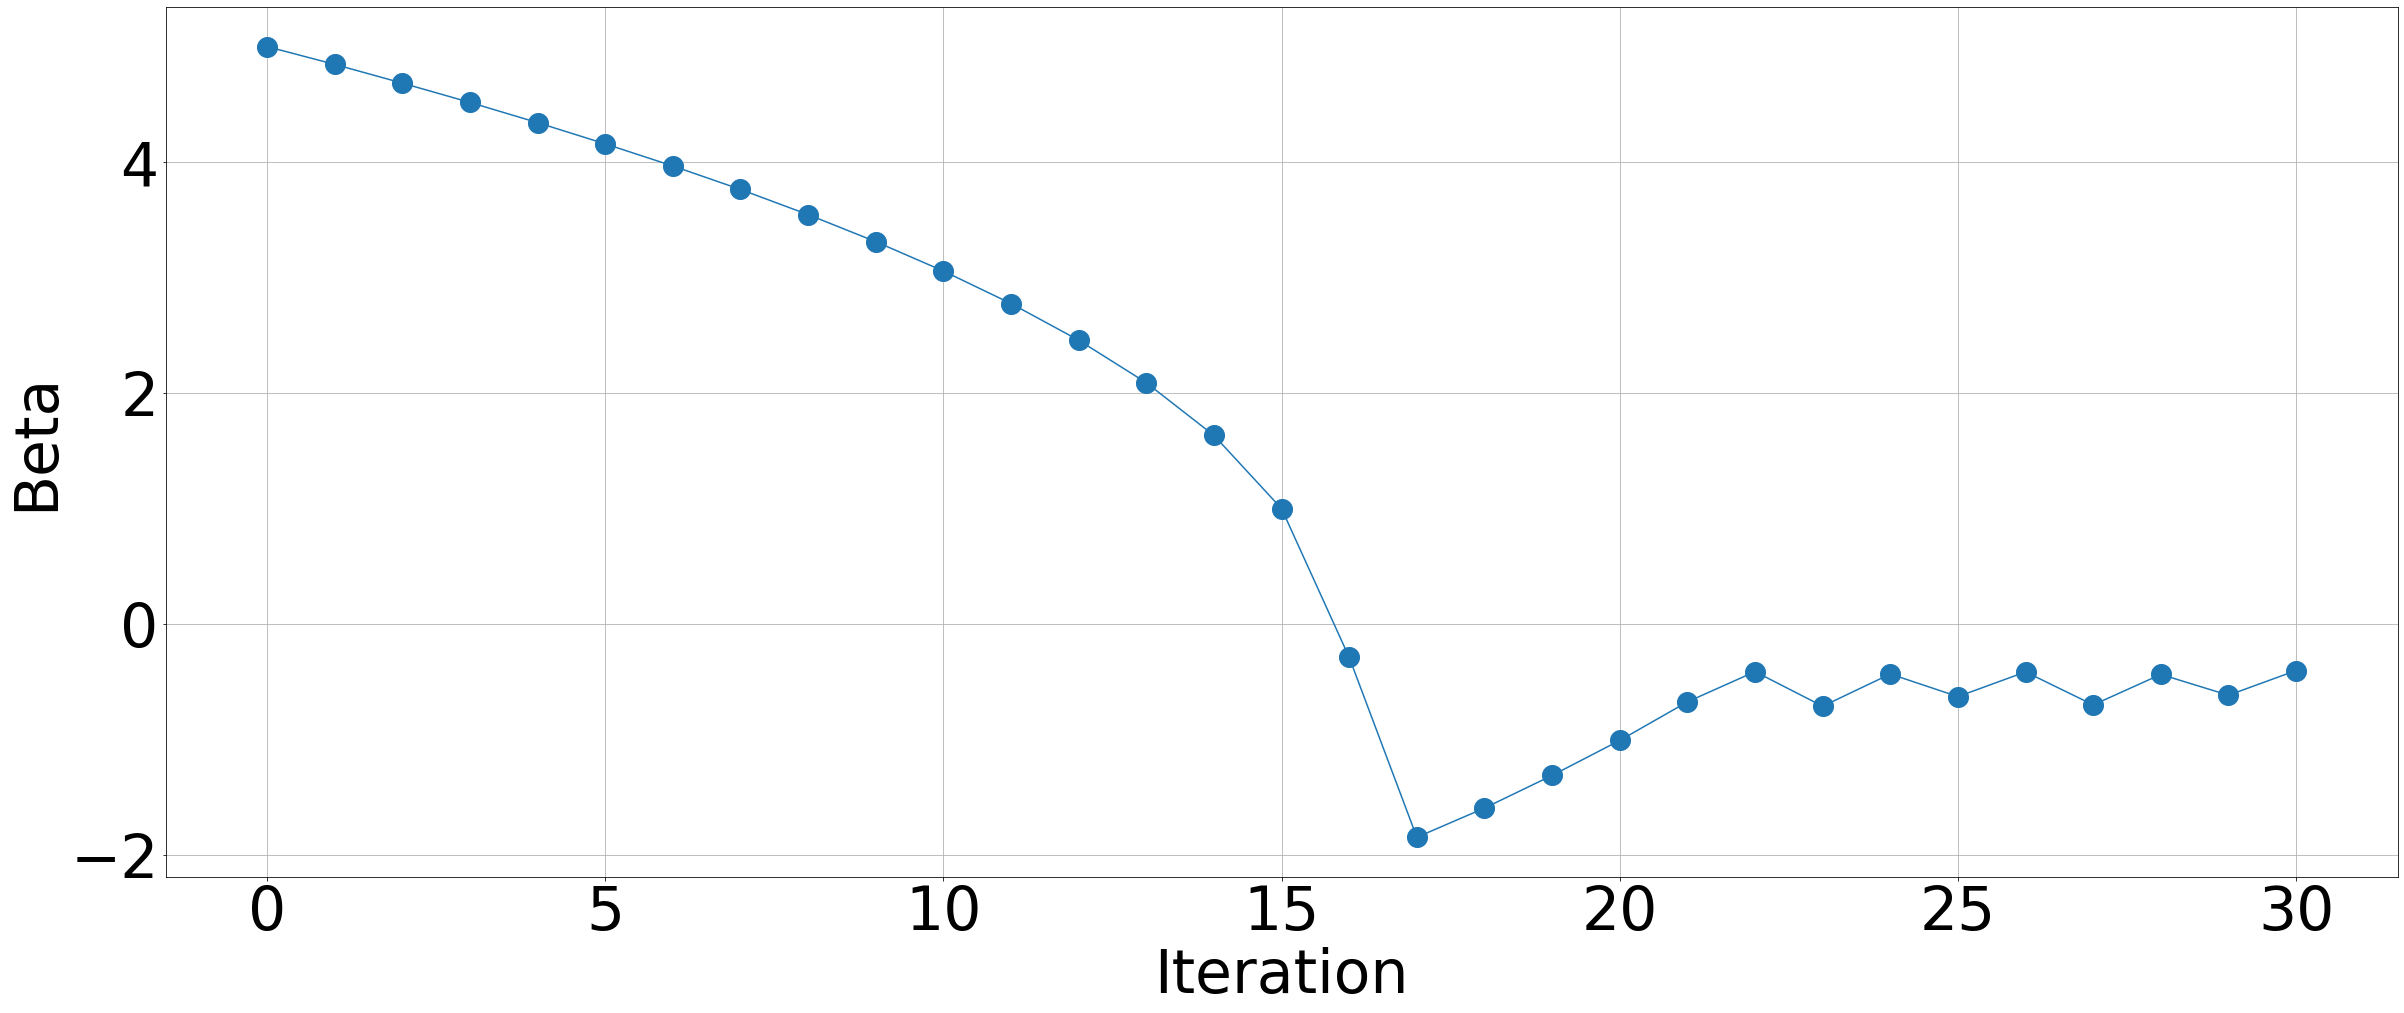

In [37]:
plot_betas(betas)

0 0.055622946470975876
1 0.06312642246484756
2 0.07454107701778412
3 0.09470579773187637
4 0.14446304738521576
5 0.7179361581802368
6 0.12957113981246948
7 0.13031920790672302
8 0.13105691969394684
9 0.13184355199337006


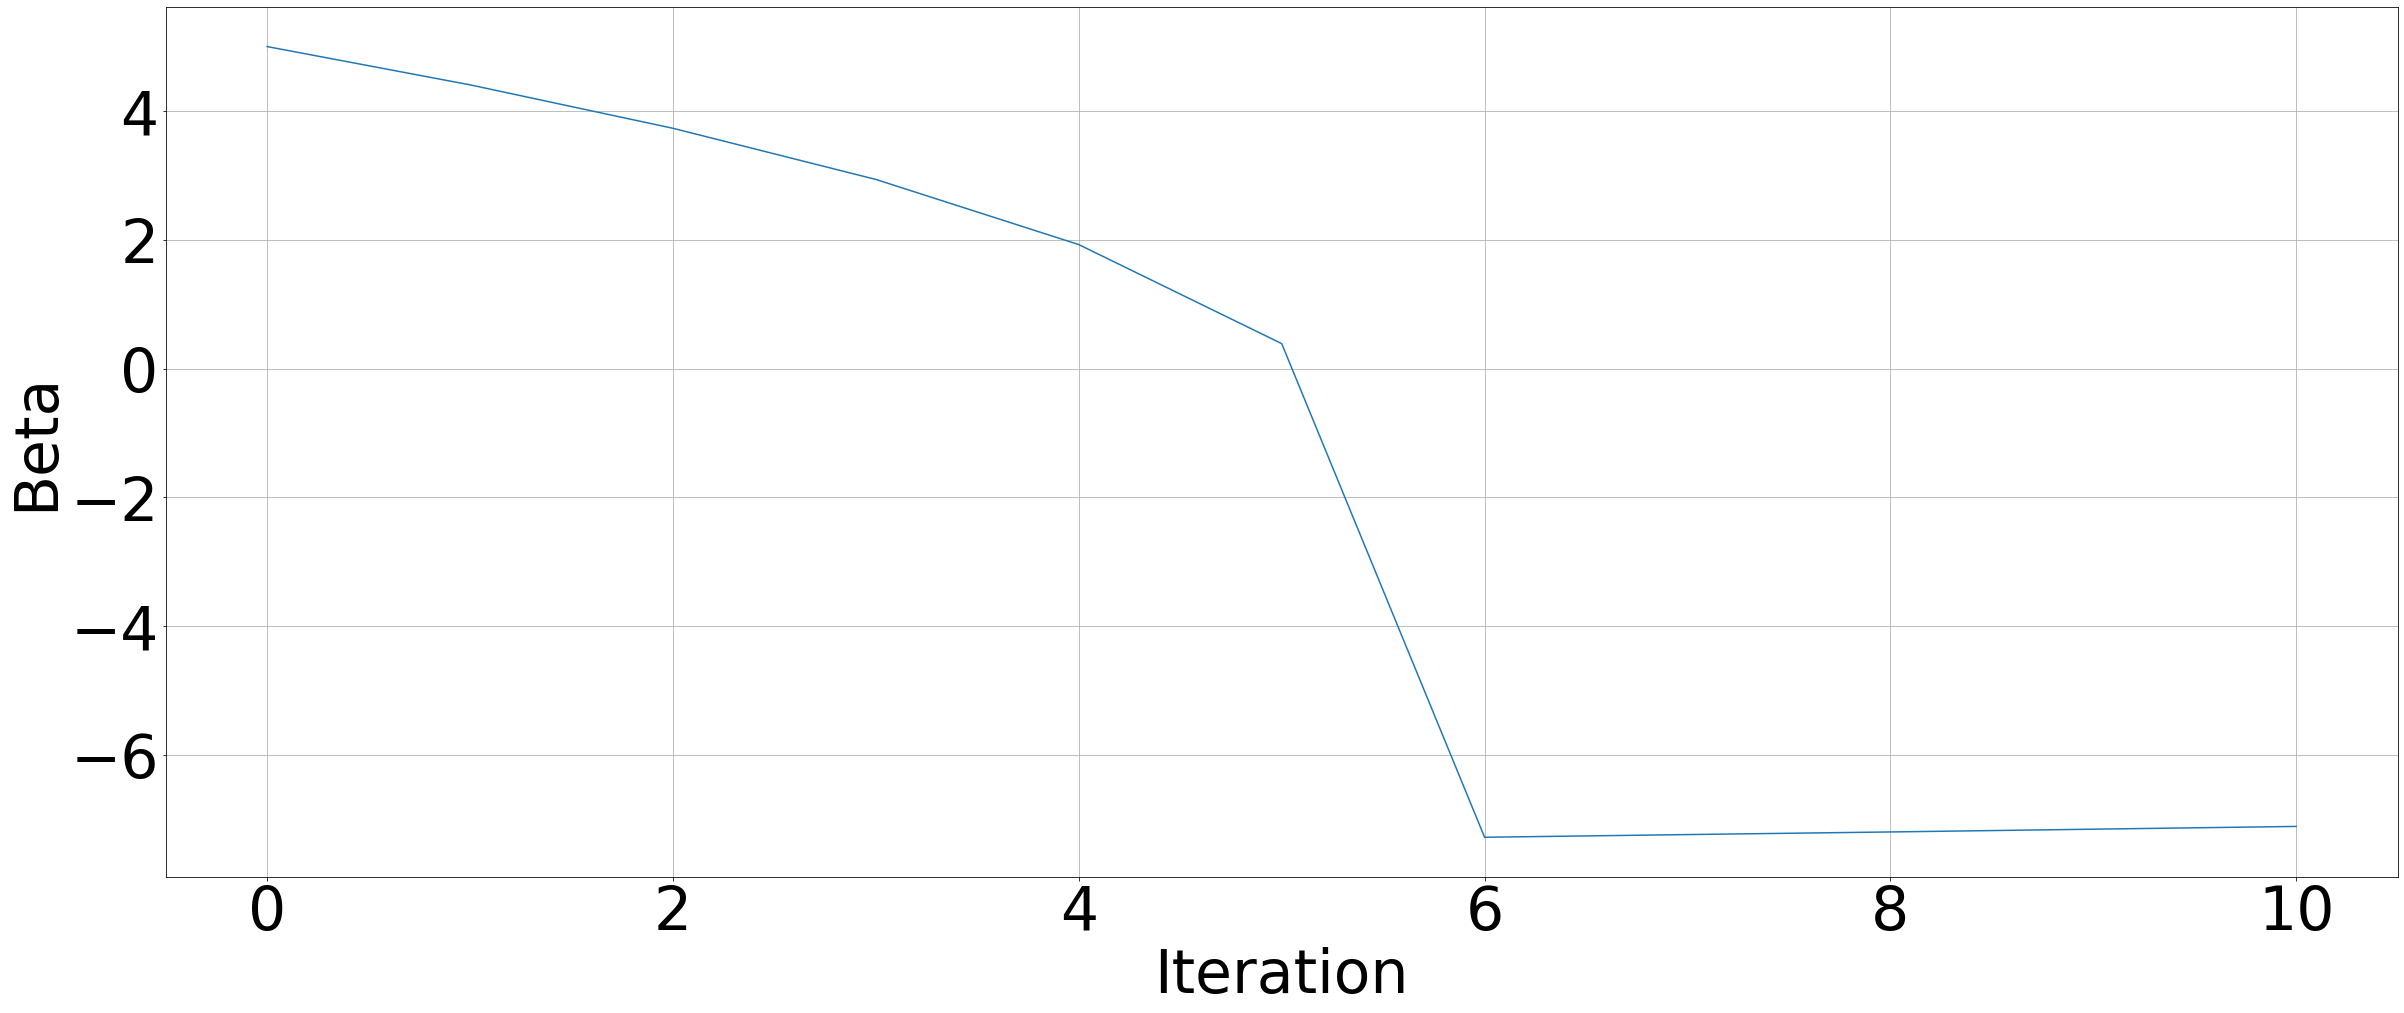

In [24]:
betas = beta_estimation_ising(num_iterations=10, lr=0.01, beta_init=5., n_reads=100,
                              crbm_sampler=crbm_sampler, dwave_sampler=qpu_sampler)
plot_betas(betas)

0 0.055622946470975876
1 0.08043315261602402
2 0.2682063579559326
3 0.08421605825424194
4 0.0885755866765976
5 0.09368965029716492
6 0.09971845149993896
7 0.10701927542686462
8 0.11617851257324219
9 0.12802234292030334


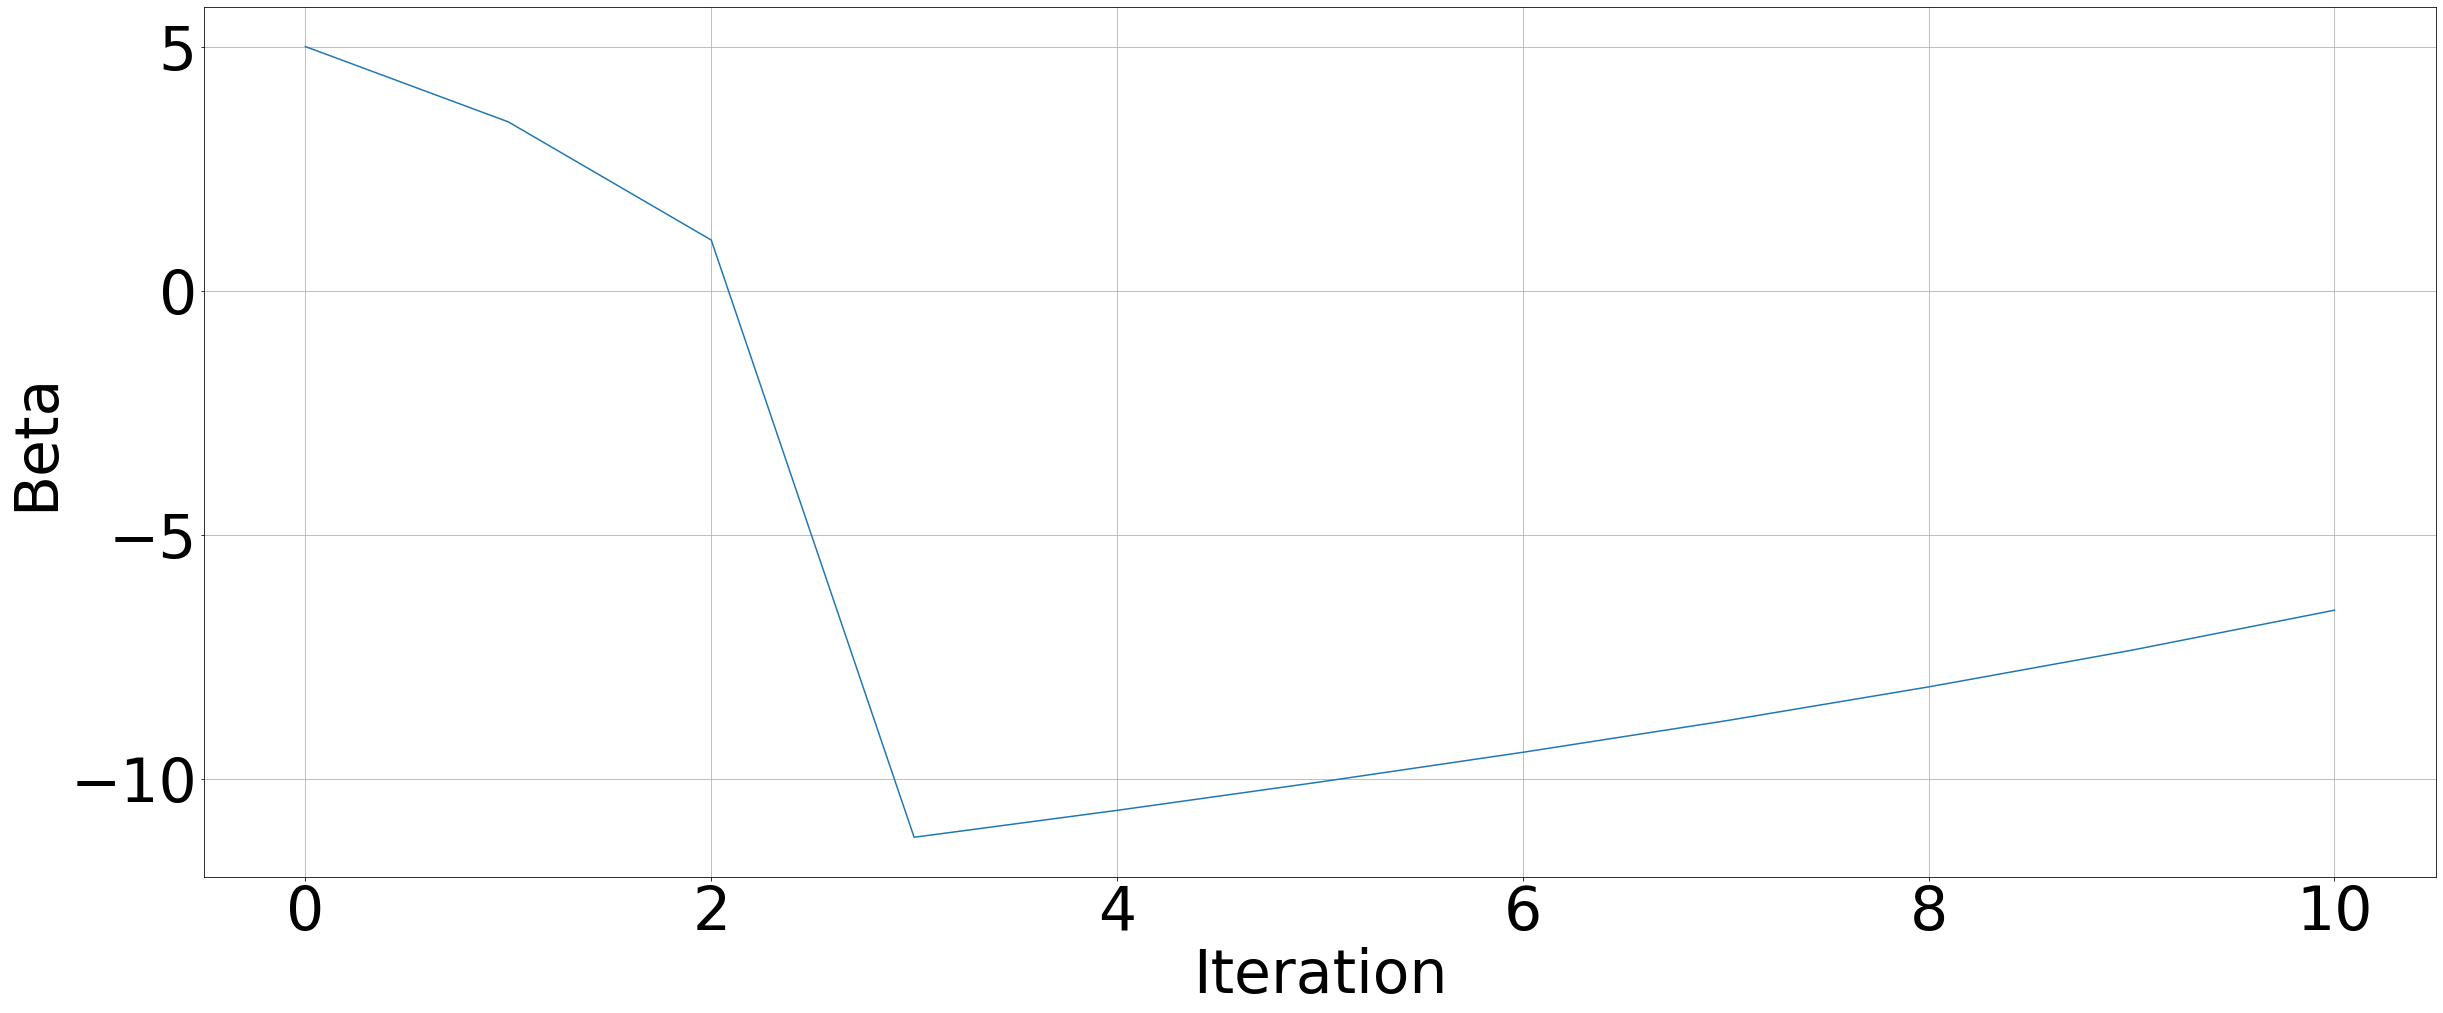

In [26]:
betas = beta_estimation_ising(num_iterations=10, lr=0.1, beta_init=5., n_reads=100,
                              crbm_sampler=crbm_sampler, dwave_sampler=qpu_sampler)
plot_betas(betas)

In [3]:
def compare_energies(beta_init=1., n_reads=1024, crbm_sampler=None, dwave_sampler=None):
    assert crbm_sampler is not None
    assert dwave_sampler is not None
    
    beta = beta_init
    
    crbm = crbm_sampler.get_rbm()
    crbm_weights, crbm_vbias, crbm_hbias = crbm.weights, crbm.visible_bias, crbm.hidden_bias
    
    ising_weights = crbm_weights/4.
    ising_vbias = crbm_vbias/2. + torch.sum(crbm_weights, dim=0)/4.
    ising_hbias = crbm_hbias/2. + torch.sum(crbm_weights, dim=1)/4.
    
    n_vis = len(crbm.visible_qubit_idxs)
    qubit_idxs = crbm.visible_qubit_idxs + crbm.hidden_qubit_idxs
    
    visible_idx_map_inv = {i:visible_qubit_idx for i, visible_qubit_idx in enumerate(crbm.visible_qubit_idxs)}
    hidden_idx_map_inv = {i:hidden_qubit_idx for i, hidden_qubit_idx in enumerate(crbm.hidden_qubit_idxs)}
    
    dwave_weights, dwave_vbias, dwave_hbias = ising_weights/beta, ising_vbias/beta, ising_hbias/beta
        
    # Calculate the autoscale factor used to fit the parameters on the device
    j_max = float(torch.max(dwave_weights))
    j_min = float(torch.min(dwave_weights))
        
    h_max = max(float(torch.max(dwave_vbias)), float(torch.max(dwave_hbias)))
    h_min = min(float(torch.min(dwave_vbias)), float(torch.min(dwave_hbias)))
    
    autoscale = max(max(j_max,0), max(j_min/-2., 0), max(h_max/2., 0), max(h_min/-2., 0))
    print(autoscale)
    
    
    dwave_weights = dwave_weights/autoscale
    dwave_vbias = dwave_vbias/autoscale
    dwave_hbias = dwave_hbias/autoscale 
        
    dwave_weights_np = dwave_weights.detach().cpu().numpy()
        
    biases = torch.cat((dwave_vbias, dwave_hbias)).detach().cpu().numpy()
    h = {qubit_idx:bias for qubit_idx, bias in zip(qubit_idxs, biases)}
    J = {}
    for row in range(dwave_weights_np.shape[0]):
        for col in range(dwave_weights_np.shape[1]):
            if dwave_weights_np[row][col] != 0:
                J[(visible_idx_map_inv[row], hidden_idx_map_inv[col])] = dwave_weights_np[row][col]
                    
    #response = dwave_sampler.sample_ising(h, J, num_reads=n_reads, auto_scale=False,
                                          #postprocess='sampling', beta=1.)
    
    response = dwave_sampler.sample_ising(h, J, num_reads=n_reads, auto_scale=False)
    dwave_samples, dwave_energies = batch_dwave_samples(response)
    dwave_samples = torch.from_numpy(dwave_samples).float()
    dwave_vis, dwave_hid = dwave_samples[:, :n_vis], dwave_samples[:, n_vis:]
        
    dwave_energies_classical = ising_energies_exp(dwave_weights, dwave_vbias, dwave_hbias,
                                                  dwave_vis, dwave_hid)
        
    crbm_vis, crbm_hid = crbm_sampler.block_gibbs_sampling()
        
    zero = torch.tensor(0., dtype=torch.float)
    minus_one = torch.tensor(-1., dtype=torch.float)
        
    crbm_vis = torch.where(crbm_vis == zero, minus_one, crbm_vis)
    crbm_hid = torch.where(crbm_hid == zero, minus_one, crbm_hid)
        
    crbm_energies_classical = ising_energies_exp(dwave_weights, dwave_vbias, dwave_hbias, crbm_vis, crbm_hid)
        
    return dwave_energies, dwave_energies_classical, crbm_energies_classical

In [6]:
_NUM_NODES = 128
crbm = QimeraRBM(n_visible=_NUM_NODES, n_hidden=_NUM_NODES)
crbm_sampler = PCD(batch_size=1024, RBM=crbm, n_gibbs_sampling_steps=100)

qpu_sampler = DWaveSampler(solver={"topology__type":"chimera"})

2022-02-22 14:25:04,673 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[14:25:04.673] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2022-02-22 14:25:05,770 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='DW_2000Q_6')
[14:25:05.770] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='DW_2000Q_6')
2022-02-22 14:25:05,872 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='Advantage_system3.2')
[14:25:05.872] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='Advantage_system3.2')
2022-02-22 14:25:06,025 dwave.cloud.client.base INFO  MainThread Adding solver StructuredSolver(id='Advantage_system4.1')
[14:25:06.025] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(id='Advantage_system4.1')
2022-02-22 14:25:06,314 dwave.cloud.

In [7]:
dwave_energies, dwave_energies_classical, crbm_energies_classical = compare_energies(crbm_sampler=crbm_sampler,
                                                                                     dwave_sampler=qpu_sampler)

1.1215436458587646


In [8]:
dwave_energies_classical = dwave_energies_classical.detach().cpu().numpy()
crbm_energies_classical = crbm_energies_classical.detach().cpu().numpy()

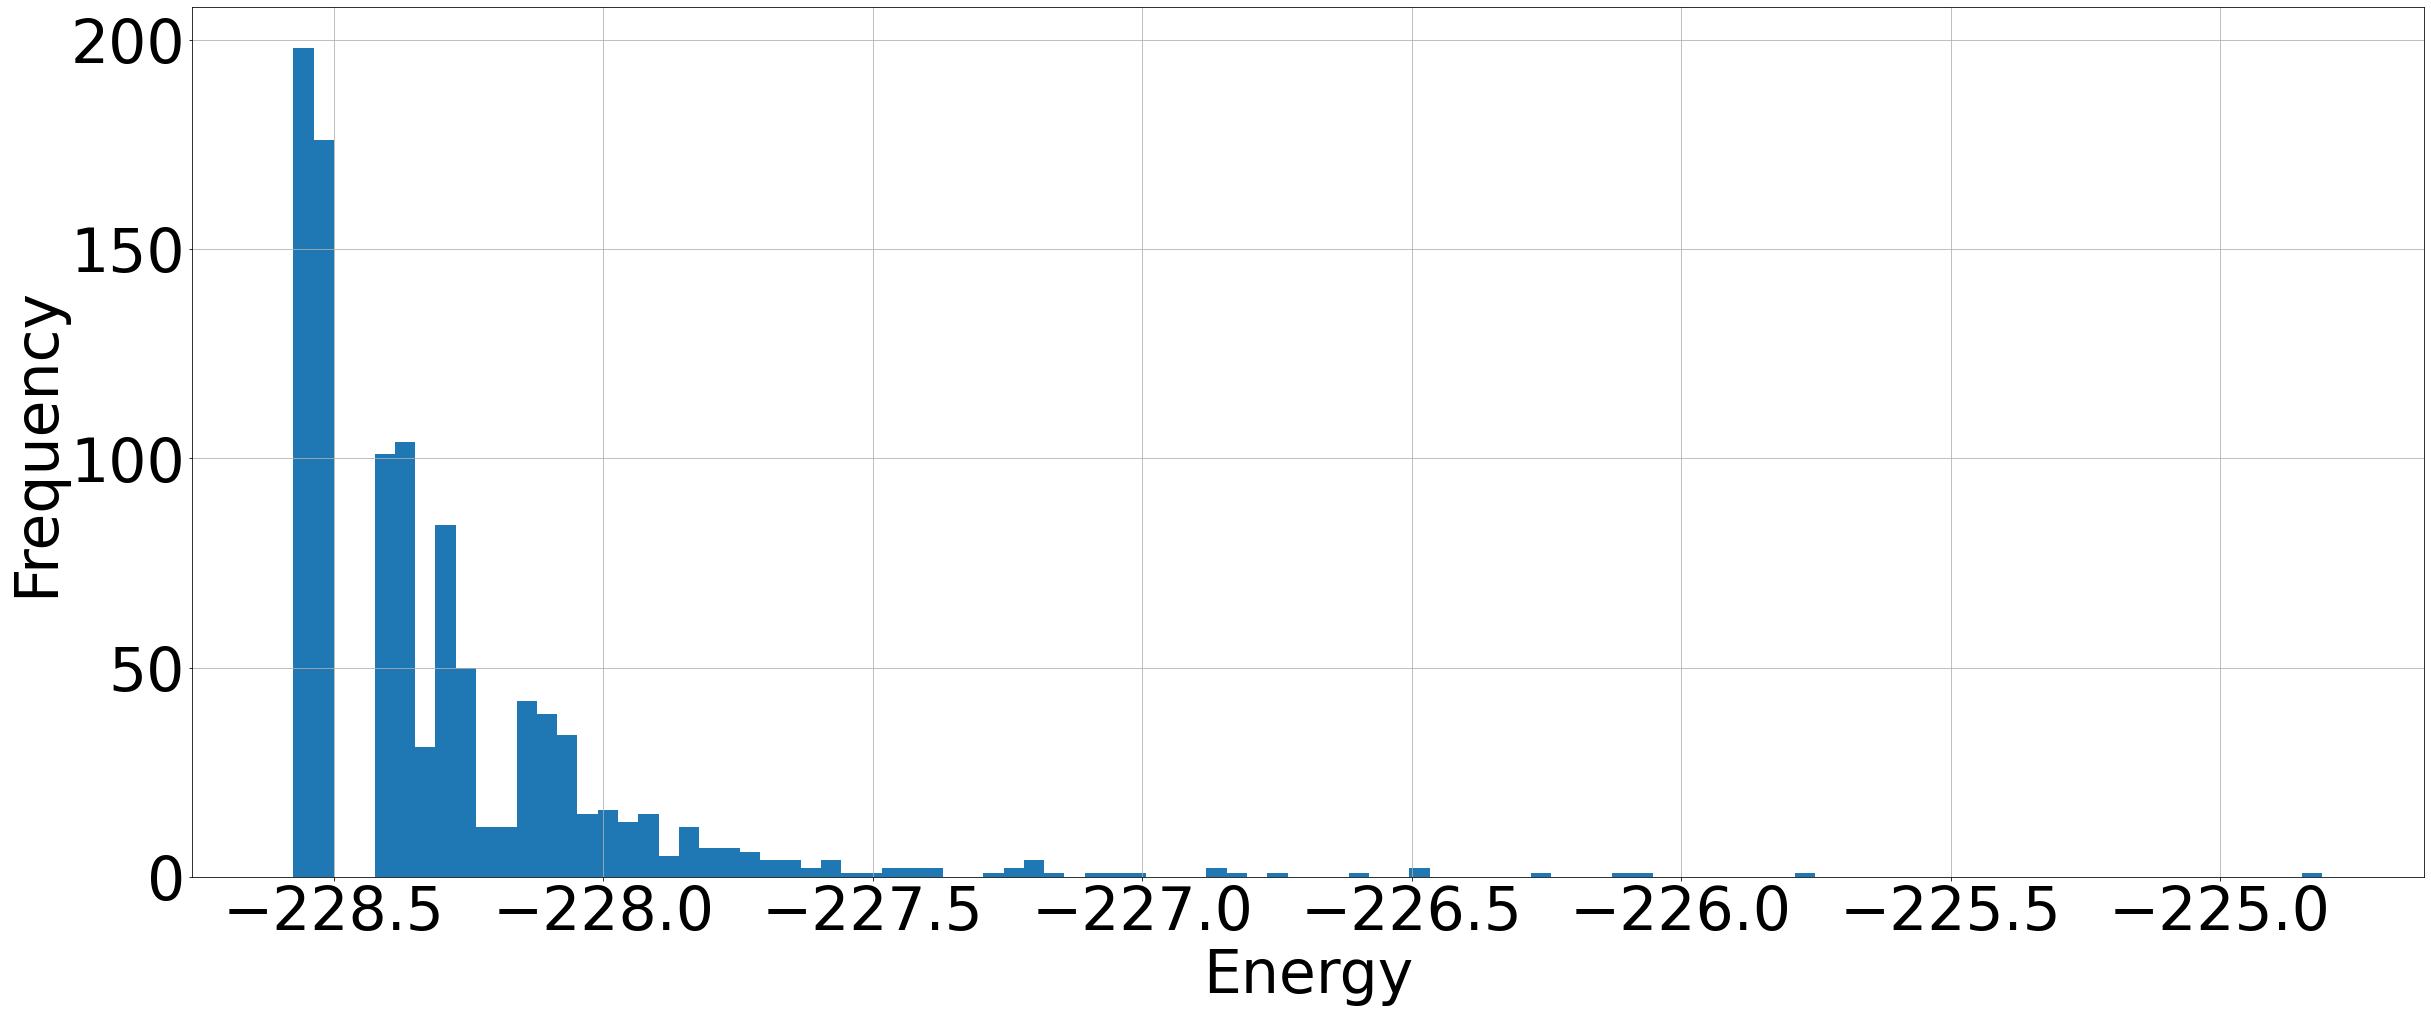

In [9]:
plot_sample_energies(dwave_energies)

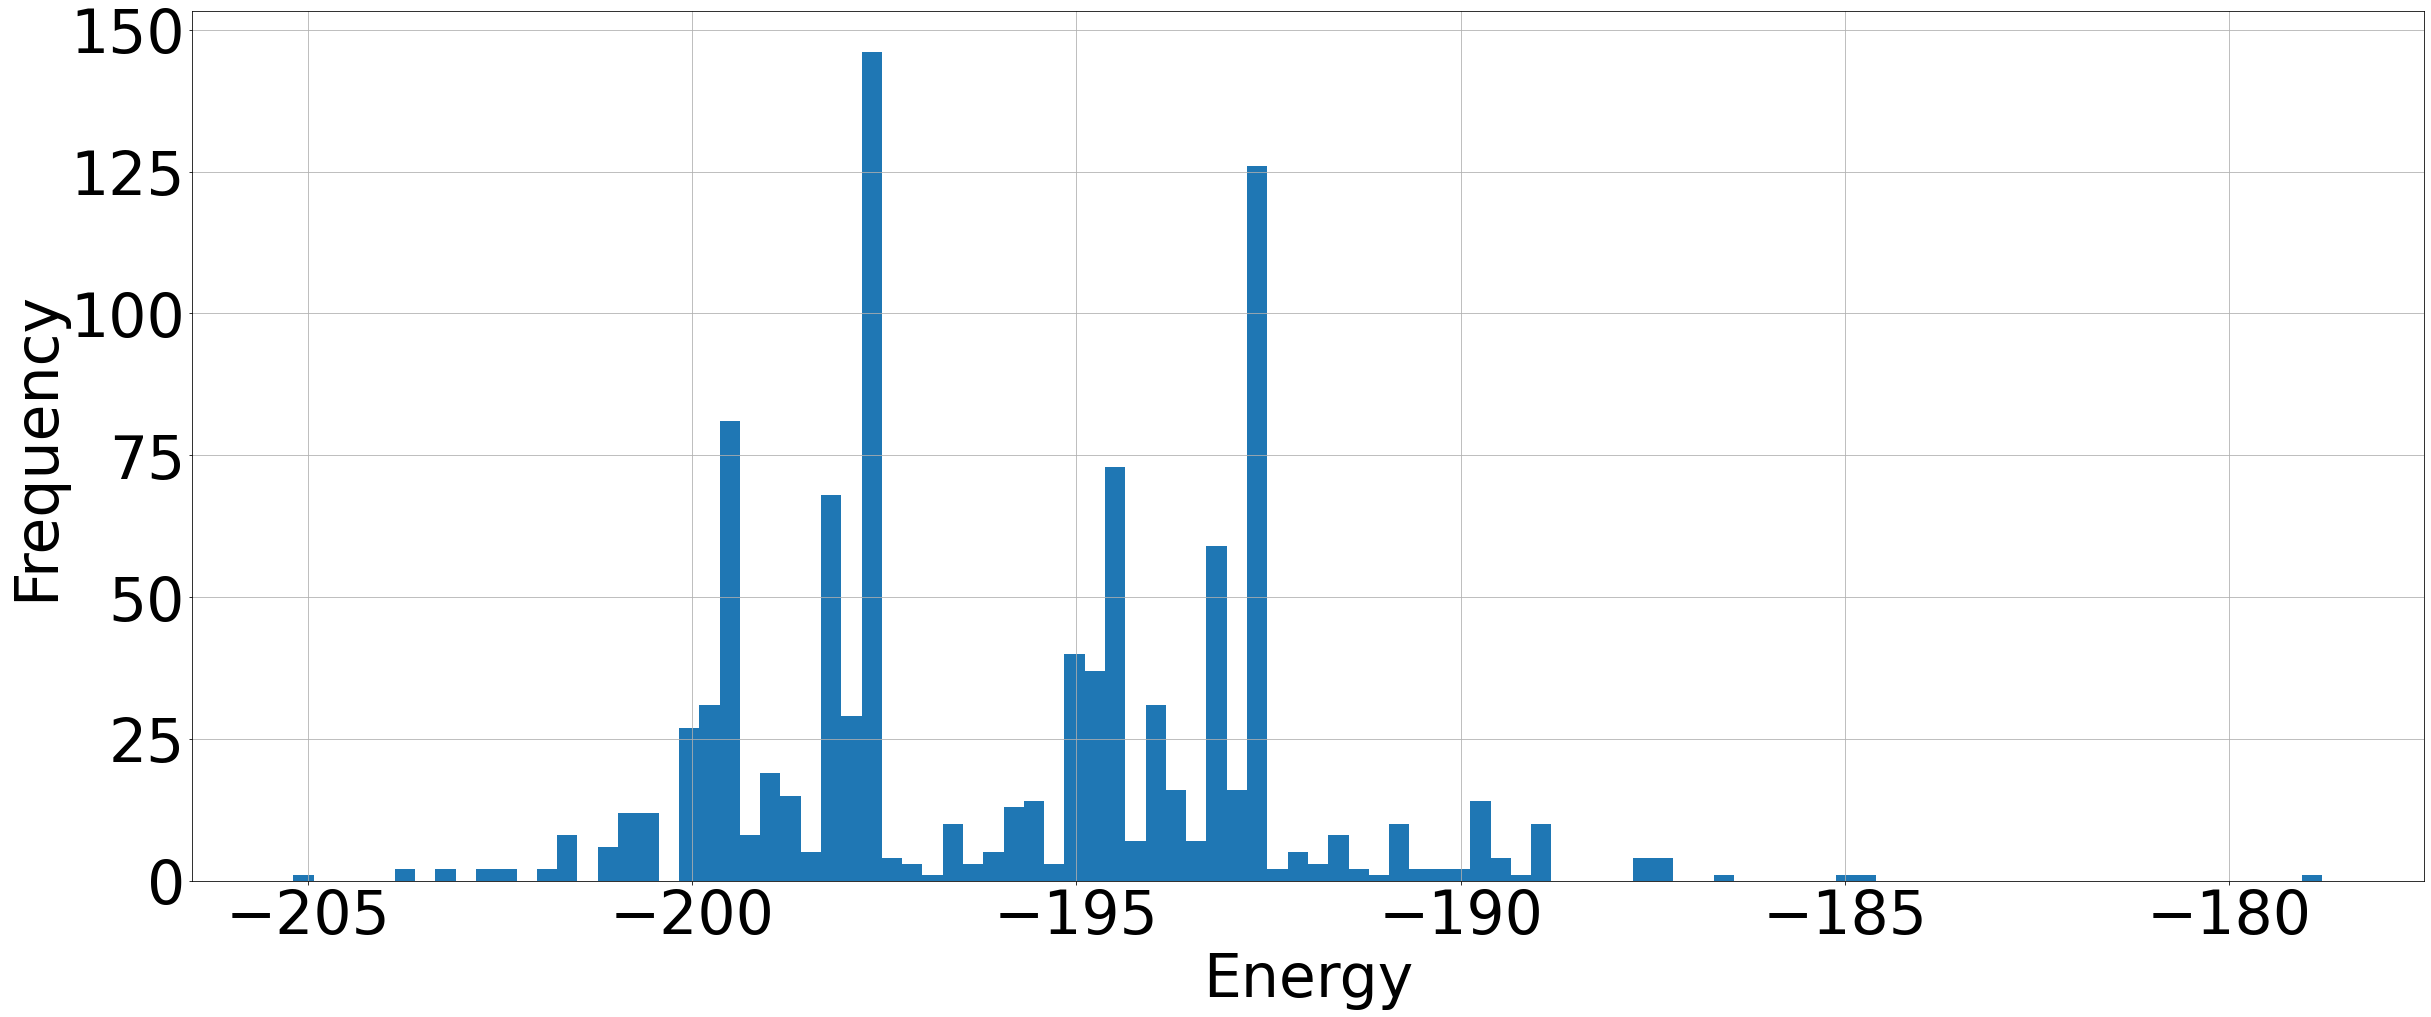

In [10]:
plot_sample_energies(dwave_energies_classical)

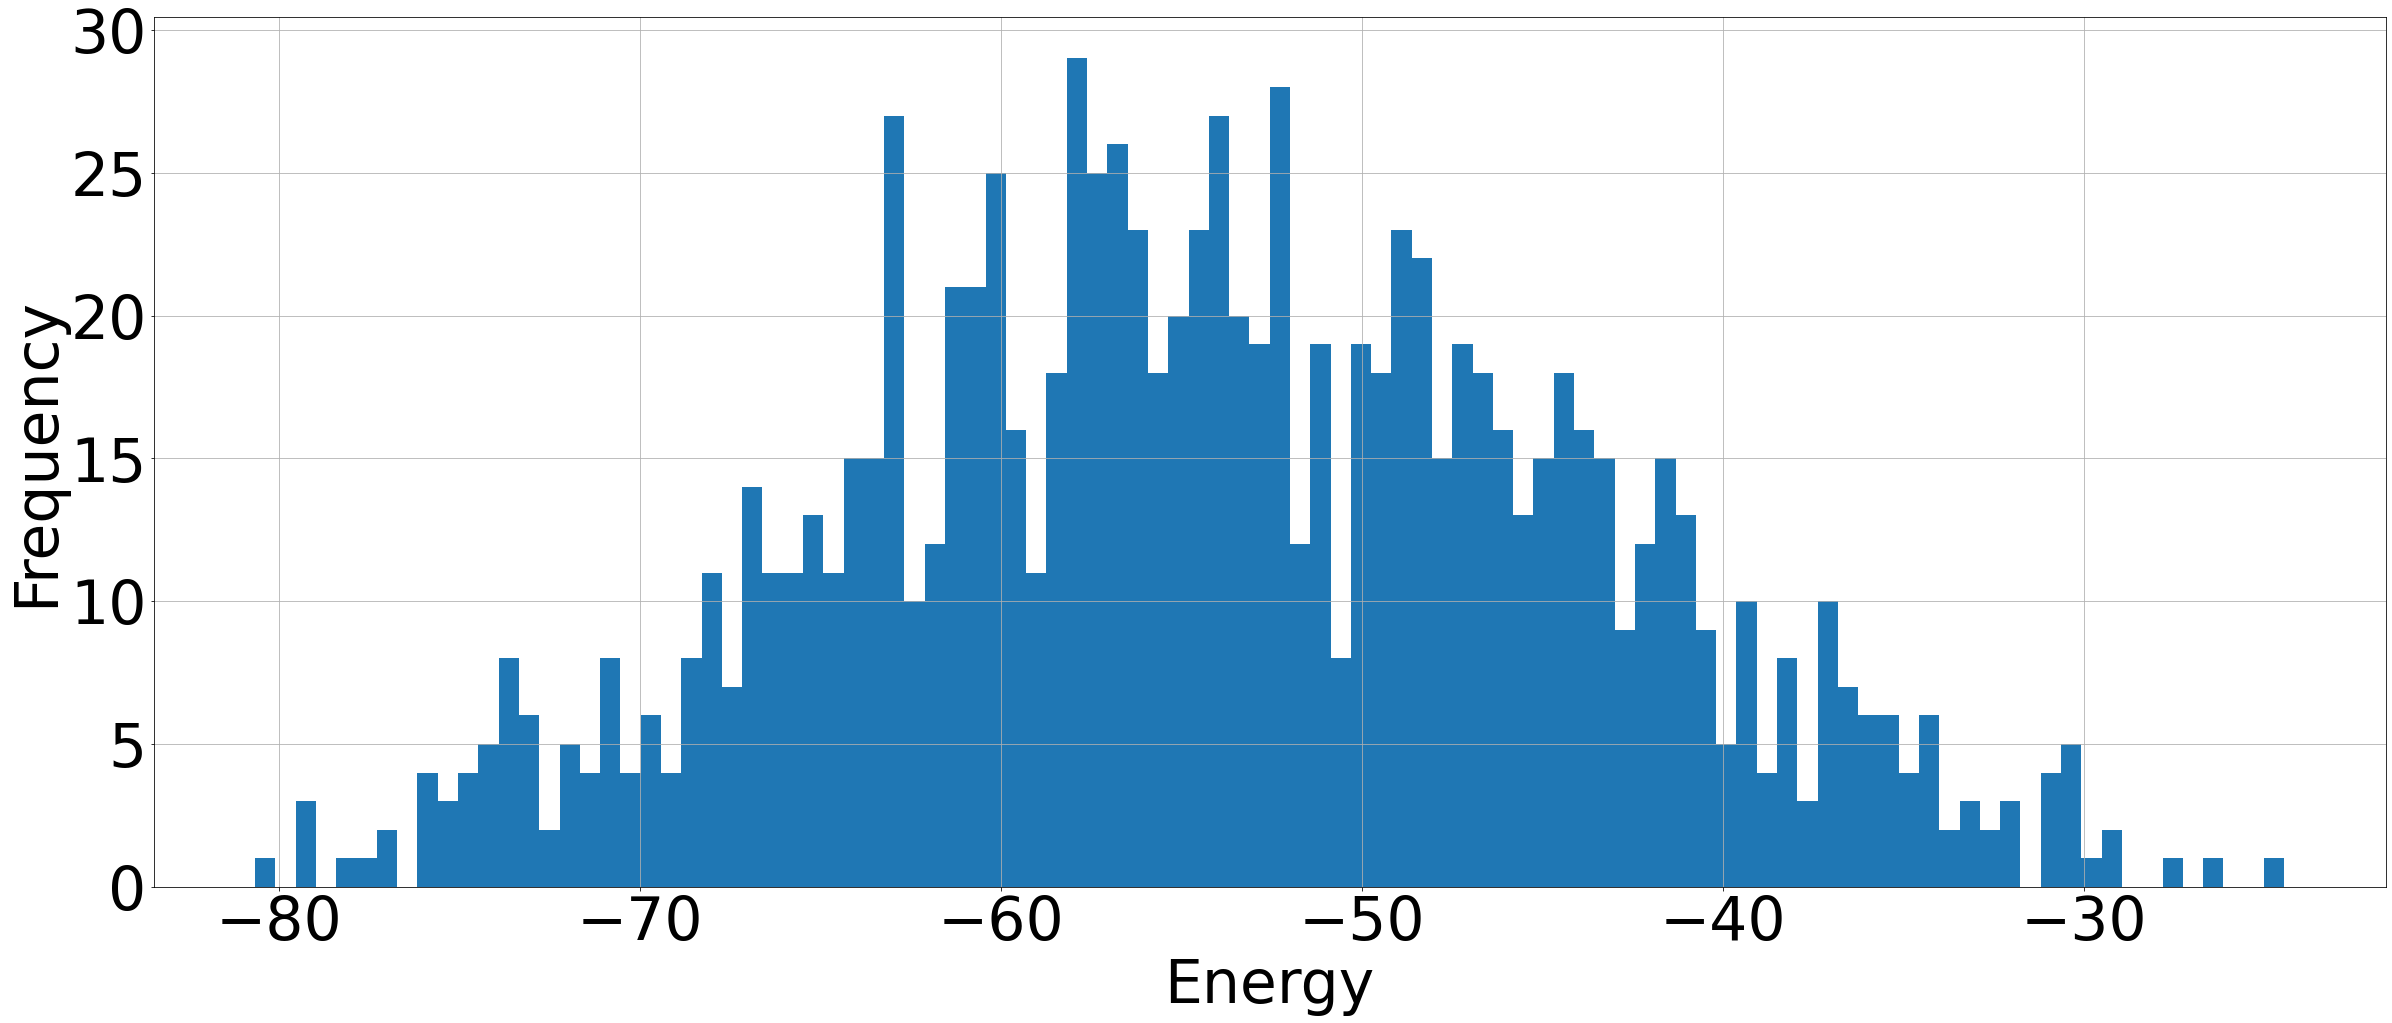

In [109]:
plot_sample_energies(crbm_energies_classical)